In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import math
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from multiproc import compute_correlations
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

## See if all sessions have finished

In [5]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = 'propofolPuffTone'
# data_class = 'leve%load_ext autoreload

In [6]:
sessions = [filename[:-4] for filename in os.listdir(os.path.join(all_data_dir, data_class)) if filename.endswith('.mat')]
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)]

In [7]:
results_dir = os.path.join(f'/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR')
finished_sessions = []
if data_class == 'propofolPuffTone':
    num_areas = 5
elif data_class == 'leverOddball':
    num_areas = 5
for session in tqdm(sessions):
    finished_windows = []
    for window in windows:
        result_path = None
        try:
            result_path = get_result_path(results_dir, session, window)
        except Exception as e:
            print(e)
#             tb.print_exception(e)
        if result_path is not None:
            if len(os.listdir(result_path)) != num_areas:
                print(f"Session {session} window {window} only has {os.listdir(result_path)}")
            else:
                missing_areas = []
                for area in os.listdir(result_path):
                    if os.path.isdir(os.path.join(result_path, area)):
                        if len(os.listdir(os.path.join(result_path, area))) == 0:
                            missing_areas.append(area)
                if len(missing_areas) > 0:
                    print(f"Missing session {session} window {window} areas {missing_areas}")
                else:
                    finished_windows.append(window)
        
    if len(finished_windows) == len(windows):
        finished_sessions.append(session)

  0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
finished_sessions

['MrJones-Anesthesia-20160105-01',
 'Mary-Anesthesia-20160818-02',
 'Mary-Anesthesia-20160912-02',
 'Mary-Anesthesia-20160902-02',
 'MrJones-Anesthesia-20160121-01',
 'Mary-Anesthesia-20160809-01',
 'MrJones-Anesthesia-20160113-01',
 'MrJones-Anesthesia-20160109-01',
 'MrJones-Anesthesia-20160210-01',
 'MrJones-Anesthesia-20160123-01',
 'Mary-Anesthesia-20160826-02',
 'MrJones-Anesthesia-20160125-01',
 'MrJones-Anesthesia-20160301-01',
 'MrJones-Anesthesia-20160201-01',
 'MrJones-Anesthesia-20160107-01',
 'Mary-Anesthesia-20160914-02',
 'MrJones-Anesthesia-20160206-01',
 'Mary-Anesthesia-20160822-02',
 'Mary-Anesthesia-20160831-02',
 'Mary-Anesthesia-20160908-02',
 'Mary-Anesthesia-20160916-02']

# Run Window Selection

In [9]:
pred_steps = 10
pct_of_value = 0.95

In [10]:
VAR_results, window_selection_info = {}, {}
for session in finished_sessions[1:]:
    print("="*20)
    print(f"SESSION = {session}")
    print("-"*20)
    run_window_selection(session, pred_steps=pred_steps, pct_of_value=pct_of_value)

SESSION = Mary-Anesthesia-20160818-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160818-02.
Window selection info found for session Mary-Anesthesia-20160818-02.
SESSION = Mary-Anesthesia-20160912-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160912-02.
Window selection info found for session Mary-Anesthesia-20160912-02.
SESSION = Mary-Anesthesia-20160902-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160902-02.
Window selection info found for session Mary-Anesthesia-20160902-02.
SESSION = MrJones-Anesthesia-20160121-01
--------------------
VAR results with selected windows found for session MrJones-Anesthesia-20160121-01.
Window selection info found for session MrJones-Anesthesia-20160121-01.
SESSION = Mary-Anesthesia-20160809-01
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160809-01.
Window selectio

In [11]:
# VAR_results, window_selection_info_path = run_window_selection(session, pred_steps=pred_steps, pct_of_value=pct_of_value, return_data=True)

In [12]:
# variables = ['sessionInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# session_info = session_vars['sessionInfo']

In [13]:
# plot_individual_areas(session, data_class, VAR_results, session_info)

# Plotting

In [14]:
area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

area_labels = {'vlPFC': 'PFC', 'FEF': '8A', '7b': 'PPC', 'CPB': 'STF', 'all': 'all'}

# Plot Figure 1

In [10]:
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

criticality_across_sessions = {}
num_indices = {}
for area in areas:
    criticality_across_sessions[area] = np.zeros((90*60*1000, )) # min*seconds*ms
    num_indices[area] = np.zeros(criticality_across_sessions[area].shape)

iterator = tqdm(total=len(finished_sessions)*len(areas))
for session in finished_sessions:
    VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)
    
    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo']
    
    for area in areas:
        df = VAR_results[area]
        
        pre_anesthesia_ind = np.argmax(df['start_time'] > (session_info['drugStart'][0] - 15*60))
#         anesthesia_start_ind = np.argmax(df['start_time'] > session_info['drugStart'][0])
#         LOC_ind = np.argmax(df['start_time'] > eyes_close)
#         anesthesia_end_ind = np.argmax(df['start_time'] > session_info['drugEnd'][1])
        post_anesthesia_ind = np.argmax(df['start_time'] > (session_info['drugEnd'][1] + 15*60))
        
        loc = 0
#         for ind in range(anesthesia_start_ind, anesthesia_end_ind):
        for ind in range(pre_anesthesia_ind, post_anesthesia_ind):
            criticality_across_sessions[area][loc:loc + int(df.iloc[ind].window*1000)] += df.iloc[ind].criticality_inds.sum()
            num_indices[area][loc:loc + int(df.iloc[ind].window*1000)] += len(df.iloc[ind].criticality_inds)
            loc += int(df.iloc[ind].window*1000)
            
        iterator.update()
        
iterator.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [11]:
mean_across_sessions = {}
for area in areas:
    end_ind = np.argmax(num_indices[area] == 0) if np.sum(num_indices[area] == 0) > 0 else len(num_indices[area])
    num_indices[area][num_indices[area] == 0] = 1
    mean_across_sessions[area] = np.divide(criticality_across_sessions[area], num_indices[area])

In [12]:
criticality_resid_across_sessions = {}
for area in areas:
    criticality_resid_across_sessions[area] = np.zeros((90*60*1000, )) # min*seconds*ms

iterator = tqdm(total=len(finished_sessions)*len(areas))
for session in finished_sessions:
    VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)
    
    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo']
    
    for area in areas:        
        df = VAR_results[area]
        
        pre_anesthesia_ind = np.argmax(df['start_time'] > (session_info['drugStart'][0] - 15*60))
#         anesthesia_start_ind = np.argmax(df['start_time'] > session_info['drugStart'][0])
#         LOC_ind = np.argmax(df['start_time'] > eyes_close)
#         anesthesia_end_ind = np.argmax(df['start_time'] > session_info['drugEnd'][1])
        post_anesthesia_ind = np.argmax(df['start_time'] > session_info['drugEnd'][1] + 15*60)
        
        loc = 0
        for ind in range(pre_anesthesia_ind, post_anesthesia_ind):
            window_means = mean_across_sessions[area][loc:loc + int(df.iloc[ind].window*1000)]
            for mean_val in np.unique(window_means):
                sse = ((df.iloc[ind].criticality_inds - mean_val)**2).sum()
                criticality_resid_across_sessions[area][loc + np.where(window_means == mean_val)[0]] += sse
            loc += int(df.iloc[ind].window*1000)
#             criticality_resid_across_sessions[area][loc:loc + int(df.iloc[ind].window*1000)] += [((df.iloc[ind].criticality_inds - m)**2).sum() for m in ]
#             loc += int(df.iloc[ind].window*1000)
            
        iterator.update()
        
iterator.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [13]:
standard_error = {}
for area in areas:
    standard_error[area] = np.divide(np.sqrt(np.divide(criticality_resid_across_sessions[area], num_indices[area])), np.sqrt(num_indices[area]))

In [14]:
session_infos = {}
for session in tqdm(finished_sessions):
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    
    session_infos[session] = session_info

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
eyes_close_times = np.zeros(len(finished_sessions))
eyes_open_times = np.zeros(len(finished_sessions))
for i, session in tqdm(enumerate(finished_sessions), total=len(finished_sessions)):
    session_info = session_infos[session]
    eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
    eyes_open = session_info['eyesOpen'][1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close_times[i] = (eyes_close - session_info['drugStart'][0])/60
    eyes_open_times[i] = (eyes_open - session_info['drugStart'][0])/60

  0%|          | 0/21 [00:00<?, ?it/s]

In [27]:
save_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/paper_figures/figure1"
os.makedirs(save_dir, exist_ok=True)
save(mean_across_sessions, os.path.join(save_dir, "mean_across_sessions"))
save(standard_error, os.path.join(save_dir, "standard_error"))
save(eyes_close_times, os.path.join(save_dir, 'eyes_close_times'))
save(eyes_open_times, os.path.join(save_dir, 'eyes_open_times'))
# mean_across_sessions = load(os.path.join(save_dir, "mean_across_sessions"))
# standard_error = load(os.path.join(save_dir, "standard_error"))
# eyes_close_times = load(os.path.join(save_dir, 'eyes_close_times'))
# eyes_open_times = load(os.path.join(save_dir, 'eyes_open_times'))

In [28]:
eyes_close_std_error = eyes_close_times.std()/np.sqrt(len(eyes_close_times))
eyes_open_std_error = eyes_open_times.std()/np.sqrt(len(eyes_open_times))

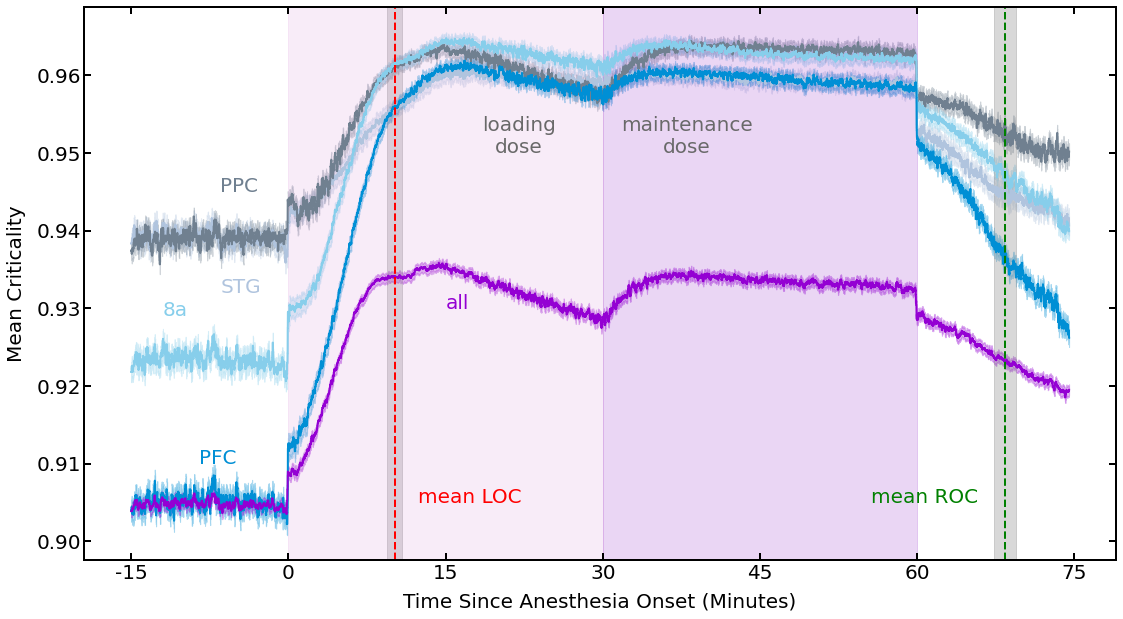

In [29]:
plt.style.use('../../sci_style.py')
# rows = 2
# cols = 3
# fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
plt.figure(figsize=(16, 9))
# axs = dict(
#     ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2),
#     ax2 = plt.subplot2grid((2,6), (0,2), colspan=2),
#     ax3 = plt.subplot2grid((2,6), (0,4), colspan=2),
#     ax4 = plt.subplot2grid((2,6), (1,1), colspan=2),
#     ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
# )

duration = 90# # minutes
time_vals = np.linspace(-15, 75, duration*60*1000)
areas = ['CPB', '7b', 'FEF', 'vlPFC', 'all']
for i, area in enumerate(areas):
# for i, area in enumerate(['vlPFC']):
#     ax = axs[int(i/cols)][i % cols]
#     ax = axs[f'ax{i+1}']
    ax = plt.gca()
    c = f"C{i}"
#     end_ind = np.argmax(num_indices[area] == 0) if np.sum(num_indices[area] == 0) > 0 else len(num_indices[area])
    end_ind = len(time_vals) - int(0.5*60*1000) # remove 30 seconds
    ax.plot(time_vals[:end_ind], mean_across_sessions[area][:end_ind], c=area_colors[area], label=area)
    ax.fill_between(time_vals[:end_ind], mean_across_sessions[area][:end_ind] - standard_error[area][:end_ind], mean_across_sessions[area][:end_ind] + standard_error[area][:end_ind], color=area_colors[area], alpha=0.3)
    
    #     ax.set_title(area)
ax = plt.gca()
min_val, max_val = ax.get_ylim()
plt.axvline(eyes_close_times.mean(), linestyle='--', c='red', label="mean LOC")
plt.axvspan(eyes_close_times.mean() - eyes_close_std_error, eyes_close_times.mean() + eyes_close_std_error, color='gray', alpha=0.3)
plt.axvline(eyes_open_times.mean(), linestyle='--', c='green', label="mean ROC")
plt.axvspan(eyes_open_times.mean() - eyes_open_std_error, eyes_open_times.mean() + eyes_open_std_error, color='gray', alpha=0.3)
plt.axvspan(0, 30, color='plum', alpha=0.2, label=f"loading dose")
plt.axvspan(30, 60, color='darkorchid', alpha=0.2, label=f"maintenance dose")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time Since Anesthesia Onset (Minutes)')
plt.xticks(np.arange(-15, 76, 15), np.arange(-15, 76, 15))
plt.ylabel('Mean Criticality')
plt.text(-8.5, 0.91, 'PFC', c = area_colors['vlPFC'])
plt.text(15, 0.93, 'all', c = area_colors['all'])
plt.text(-12, 0.929, '8a', c = area_colors['FEF'])
plt.text(-6.5, 0.945, 'PPC', c = area_colors['7b'])
plt.text(-6.5, 0.932, 'STG', c = area_colors['CPB'])
plt.text(eyes_close_times.mean() + eyes_close_std_error + 1.5, 0.905, 'mean LOC', c = 'r')
plt.text(eyes_open_times.mean() - eyes_open_std_error - 1.5, 0.905, 'mean ROC', c = 'g', ha='right')
plt.text(22, 0.95, 'loading\ndose', c = 'dimgray', ha='center')
plt.text(38, 0.95, 'maintenance\ndose', c = 'dimgray', ha='center')
ax.relim()
# plt.tick_params(labelsize=13)
plt.tight_layout()
plt.show()

# Plot Figure 2

In [48]:
# session = 'Mary-Anesthesia-20160912-02'
session = 'Mary-Anesthesia-20160809-01'

In [49]:
VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo']

In [50]:
# function to calculate LCM
def LCMofArray(a):
    lcm = a[0]
    for i in range(1,len(a)):
        lcm = lcm*a[i]//math.gcd(lcm, a[i])
    return lcm

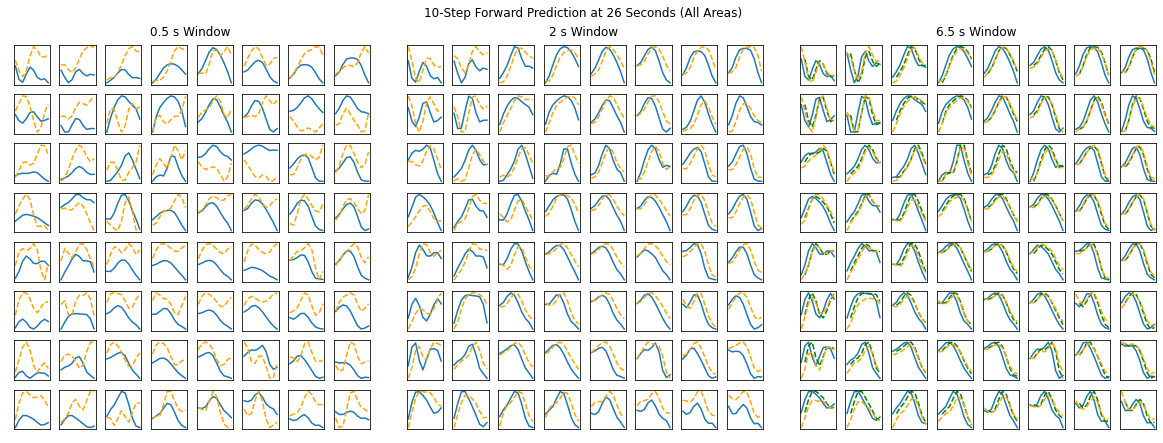

In [51]:
fig = plt.figure(constrained_layout=True, figsize=(16, 6))
subfigs = fig.subfigures(1, 3, wspace=0.07)

rows = 8
cols = 8

area = 'all'

window1 = 0.5
window2 = 2
window3 = 6.5

time_in_session = LCMofArray(np.int0(np.array([window1, window2, window3])*10))/10 # s

subfigs[0].suptitle(f"{window1} s Window")
subfigs[1].suptitle(f"{window2} s Window")
subfigs[2].suptitle(f"{window3} s Window")

axsLeft = subfigs[0].subplots(rows, cols, sharex=True)

window_loc = int(time_in_session/window1) - 1
for i in range(rows*cols):
    ax = axsLeft[int(i/cols)][i % cols]
    ax.plot(window_selection_info['true_vals'][area][window1][window_loc, :, i])
    ax.plot(window_selection_info['predictions'][area][window1][window_loc, :, i], c='orange', linestyle='--')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axsCenter = subfigs[1].subplots(8, 8, sharex=True)


window_loc = int(time_in_session/window2) - 1
for i in range(rows*cols):
    ax = axsCenter[int(i/cols)][i % cols]
    ax.plot(window_selection_info['true_vals'][area][window2][window_loc, :, i])
    ax.plot(window_selection_info['predictions'][area][window2][window_loc, :, i], c='orange', linestyle='--')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
axsRight = subfigs[2].subplots(8, 8, sharex=True)


window_loc = int(time_in_session/window3) - 1
for i in range(rows*cols):
    ax = axsRight[int(i/rows)][i % cols]
    ax.plot(window_selection_info['true_vals'][area][window3][window_loc, :, i])
    ax.plot(np.arange(1, 10), window_selection_info['true_vals'][area][window3][window_loc, :-1, i], c='green', linestyle='--')
    ax.plot(window_selection_info['predictions'][area][window3][window_loc, :, i], c='orange', linestyle='--')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle(f"10-Step Forward Prediction at {int(time_in_session)} Seconds (All Areas)")
plt.show()

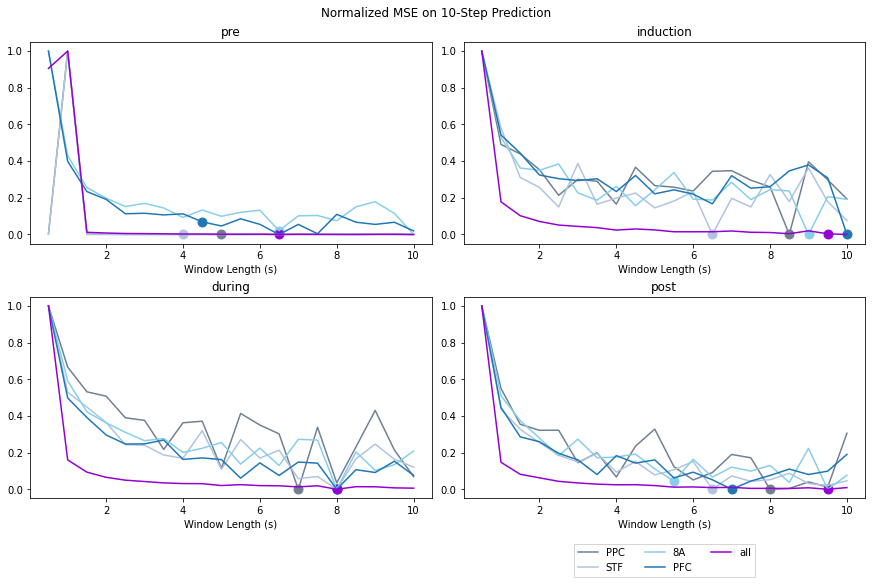

In [52]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8))
window_sizes = np.arange(0.5, 10.1, 0.5)

# subfigs[0].set_facecolor('0.75')
# for ax in axsLeft:
#     pc = example_plot(ax)
# # subfigs[0].suptitle('Left plots', fontsize='x-large')
# subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

for i, key in enumerate(['pre', 'induction', 'during', 'post']):
    ax = axs[int(i/2
                )][i%2]
    for area in window_selection_info['window_mses'][key].keys():
        vals = np.array(window_selection_info['window_mses'][key][area])
        vals = (vals - vals.min())/(vals.max() - vals.min())
        selected_window = window_selection_info['selected_windows'][key][area]
        selected_window_val = vals[window_sizes == selected_window]
        ax.plot(window_sizes, vals, label=area_labels[area], c=area_colors[area])
        ax.scatter(selected_window, selected_window_val, c=area_colors[area], s=80)
    ax.set_title(key)
    ax.set_xlabel('Window Length (s)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3)
plt.suptitle("Normalized MSE on 10-Step Prediction")
plt.show()

# Plot Figure 3

In [9]:
# min_before = np.Inf
# min_after = np.inf
# for session in tqdm(finished_sessions):
#     variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo']
#     session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
#     electrode_info, lfp_schema, session_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo']
    
#     print(f"session = {session}")
#     print(f"Time before anesthesia: {session_info['drugStart'][0]}")
#     if session_info['drugStart'][0] < min_before:
#         min_before = session_info['drugStart'][0]
#     print(f"Time after anesthesia: {(T/1000) - session_info['drugEnd'][1]}")
#     if (T/1000) - session_info['drugEnd'][1] < min_after:
#         min_after = (T/1000) - session_info['drugEnd'][1]

In [10]:
summary_stats = []
# iterator = tqdm(total=len(finished_sessions)*4)
iterator = tqdm(total=len(finished_sessions)*5)
for session in finished_sessions:
    VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)
    
    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo']
    
    # compute summary stats
    for area in VAR_results.keys():
#         if area != 'all':
        stat_dict = compute_summary_statistics(VAR_results[area], session_info)
        stat_dict['session'] = session
        stat_dict['area'] = area

        summary_stats.append(stat_dict)

        iterator.update()
iterator.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [11]:
stats_df = pd.DataFrame(summary_stats)
stats_df['monkey'] = stats_df.session.apply(lambda x: 1 if x.startswith('Mary') else 2)

In [12]:
save_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/paper_figures/figure3"
os.makedirs(save_dir, exist_ok=True)
save(stats_df, os.path.join(save_dir, "stats_df"))
# stats_df = load(os.path.join(save_dir, "stats_df"))

In [13]:
p_thresh = 0.05
summary_dict = {}
# for area in ['vlPFC', 'FEF', '7b', 'CPB']:
for area in ['vlPFC', 'FEF', '7b', 'CPB', 'all']:
    area_stats = stats_df[stats_df['area'] == area]
    prop_significant = np.sum(area_stats.mannwhitney_p < p_thresh)/len(area_stats)
    
    avg_beta = area_stats.beta.mean()
    se_beta = area_stats.beta.std()/np.sqrt(len(area_stats))
    avg_r2 = area_stats.r2_score.mean()
    se_r2 = area_stats.r2_score.std()/np.sqrt(len(area_stats))
    ratios = area_stats['anesthesia_mean']/area_stats['wake_mean']
    avg_ratio = ratios.mean()
    se_ratio = ratios.std()/np.sqrt(len(ratios))
    diffs = area_stats['anesthesia_mean'] - area_stats['wake_mean']
    avg_diffs = diffs.mean()
    se_diffs = diffs.std()/np.sqrt(len(diffs))
    
    summary_dict[area] = dict(
        prop_significant=prop_significant,
        avg_beta=avg_beta,
        se_beta=se_beta,
        avg_r2=avg_r2,
        se_r2=se_r2,
        ratios=ratios,
        avg_ratio=avg_ratio,
        se_ratio=se_ratio,
        diffs=diffs,
        avg_diffs=avg_diffs,
        se_diffs=se_diffs
    )
    
    
    print(f"AREA = {area}")
    print(f"Proportion of sessions with significant difference in anesthesia: {prop_significant}")
    print(f"Mean Rate: {avg_beta:.2e} +/- {se_beta:.2e} s^-1, Mean R2: {avg_r2:.3f} +/- {se_r2:.3f}")
    print(f"Ratio of anesthesia to wake: {avg_ratio:.3f} +/- {se_ratio:.3f}, ")

AREA = vlPFC
Proportion of sessions with significant difference in anesthesia: 1.0
Mean Rate: 8.06e-05 +/- 7.09e-06 s^-1, Mean R2: 0.960 +/- 0.004
Ratio of anesthesia to wake: 1.061 +/- 0.002, 
AREA = FEF
Proportion of sessions with significant difference in anesthesia: 1.0
Mean Rate: 6.08e-05 +/- 2.50e-06 s^-1, Mean R2: 0.927 +/- 0.010
Ratio of anesthesia to wake: 1.044 +/- 0.002, 
AREA = 7b
Proportion of sessions with significant difference in anesthesia: 1.0
Mean Rate: 3.94e-05 +/- 2.88e-06 s^-1, Mean R2: 0.857 +/- 0.012
Ratio of anesthesia to wake: 1.029 +/- 0.004, 
AREA = CPB
Proportion of sessions with significant difference in anesthesia: 0.8095238095238095
Mean Rate: 2.94e-05 +/- 3.93e-06 s^-1, Mean R2: 0.756 +/- 0.056
Ratio of anesthesia to wake: 1.026 +/- 0.005, 
AREA = all
Proportion of sessions with significant difference in anesthesia: 1.0
Mean Rate: 5.46e-05 +/- 2.19e-06 s^-1, Mean R2: 0.951 +/- 0.004
Ratio of anesthesia to wake: 1.034 +/- 0.002, 


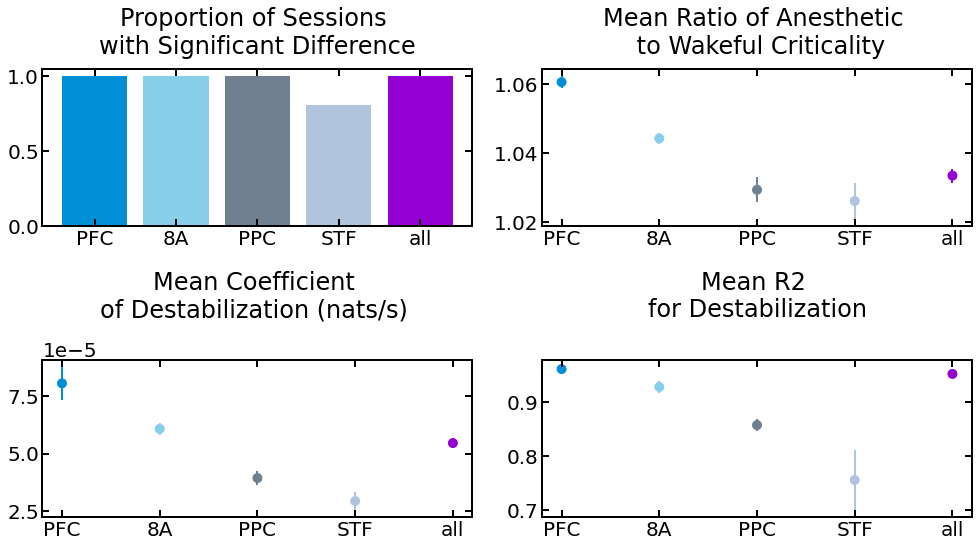

In [18]:
plt.style.use('../../sci_style.py') 
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 8))

areas = summary_dict.keys()

# plot proportion significant 
ax = axs[0][0]
ax.bar([area_labels[area] for area in areas], [summary_dict[area]['prop_significant'] for area in areas], color=[area_colors[a] for a in areas])
ax.set_title("Proportion of Sessions \nwith Significant Difference")

# Mean Ratio of Anesthestic Criticality to Wake Criticality Across Sessions
ax = axs[0][1]
ax.errorbar([area_labels[area] for area in areas], [summary_dict[area]['avg_ratio'] for area in areas], yerr=[summary_dict[area]['se_ratio'] for area in areas], ecolor=[area_colors[a] for a in areas], fmt='b', linestyle='none')
ax.scatter([area_labels[area] for area in areas], [summary_dict[area]['avg_ratio'] for area in areas], c=[area_colors[a] for a in areas],s=80)
ax.set_title("Mean Ratio of Anesthetic \n to Wakeful Criticality")

# Mean Differences of Anesthestic Criticality to Wake Criticality Across Sessions
# ax = axs[0][1]
# ax.errorbar(areas, [summary_dict[area]['avg_diffs'] for area in areas], yerr=[summary_dict[area]['se_diffs'] for area in areas], ecolor=[area_colors[a] for a in areas], fmt='b', linestyle='none')
# ax.scatter(areas, [summary_dict[area]['avg_diffs'] for area in areas], c=[area_colors[a] for a in areas],s=80)
# ax.set_title("Mean Difference of Anesthetic \n to Wakeful Criticality")

# Average Beta
ax = axs[1][0]
ax.scatter([area_labels[area] for area in areas], [summary_dict[area]['avg_beta'] for area in areas], c=[area_colors[a] for a in areas], s=80)
ax.errorbar([area_labels[area] for area in areas], [summary_dict[area]['avg_beta'] for area in areas], yerr=[summary_dict[area]['se_beta'] for area in areas], ecolor=[area_colors[a] for a in areas], fmt='b', linestyle='none')
ax.set_title("Mean Coefficient \nof Destabilization (nats/s) \n")

# Average R2
ax = axs[1][1]
ax.scatter([area_labels[area] for area in areas], [summary_dict[area]['avg_r2'] for area in areas], c=[area_colors[a] for a in areas], s=80)
ax.errorbar([area_labels[area] for area in areas], [summary_dict[area]['avg_r2'] for area in areas], yerr=[summary_dict[area]['se_r2'] for area in areas], ecolor=[area_colors[a] for a in areas], fmt='b', linestyle='none')
ax.set_title("Mean R2 \nfor Destabilization\n")



plt.tight_layout()
plt.show()